<a href="https://colab.research.google.com/github/lucasswolff/Machine-Learning-Projects/blob/main/Car_Evaluation_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project was made by Lucas Wolff as a classification study case. The main goal is to create a model to predict the evaluation of a car beased on its features. 
The original dataset can be found in following link: https://code.datasciencedojo.com/datasciencedojo/datasets/tree/master/Car%20Evaluation

The dataset has 7 columns and 1728  rows. The columns are the following:

1) buying: Buying price of the car (v-high, high, med, low)

2) maint: Price of the maintenance of car (v-high, high, med, low)

3) doors: Number of doors (2, 3, 4, 5-more)

4) persons: Capacity in terms of persons to carry (2, 4, more)

5) lug_boot: The size of luggage boot (small, med, big)

6) safety: Estimated safety of the car (low, med, high)

7) class: Car acceptability (unacc: unacceptable, acc: acceptable, good: good, v-good: very good)

# Importing libraries and the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#cross validation
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.model_selection import cross_validate

#ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

#preprocessing
from sklearn.preprocessing import OrdinalEncoder

#metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score

In [2]:
!mkdir -p '/content/drive/MyDrive/Colab Datasets/car-evaluation' #create directory in Google Drive
!wget -P '/content/drive/MyDrive/Colab Datasets/car-evaluation' https://code.datasciencedojo.com/datasciencedojo/datasets/raw/master/Car%20Evaluation/car.data

--2022-03-30 19:59:44--  https://code.datasciencedojo.com/datasciencedojo/datasets/raw/master/Car%20Evaluation/car.data
Resolving code.datasciencedojo.com (code.datasciencedojo.com)... 167.99.111.153
Connecting to code.datasciencedojo.com (code.datasciencedojo.com)|167.99.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51867 (51K) [text/plain]
Saving to: ‘/content/drive/MyDrive/Colab Datasets/car-evaluation/car.data’

car.data            100%[===================>]  50.65K  --.-KB/s    in 0.1s    

2022-03-30 19:59:45 (355 KB/s) - ‘/content/drive/MyDrive/Colab Datasets/car-evaluation/car.data’ saved [51867/51867]



In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Datasets/car-evaluation/car.data')

In [4]:
df.columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'classification']

In [5]:
df.head()

,buying,maint,doors,persons,lug_boot,safety,classification
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1727 entries, 0 to 1726
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   buying          1727 non-null   object
 1   maint           1727 non-null   object
 2   doors           1727 non-null   object
 3   persons         1727 non-null   object
 4   lug_boot        1727 non-null   object
 5   safety          1727 non-null   object
 6   classification  1727 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [7]:
df.isnull().sum().max()

0

We can see the data type of all columns is a string. Even for the columns doors and persons, which has de values 5-more and more respectively.
There is no missing values

# Exploratoy Data Analysis 

Let's take a look in the data

How many cars do you think is unacceptable? What about the good ones?

In [8]:
#altering the Pandas' graph style
#pd.options.plotting.backend = 'plotly'

In [9]:
#Changing the sort order
df['buying'] = pd.Categorical(df['buying'], ['low', 'med', 'high', 'vhigh'])
df['maint'] = pd.Categorical(df['maint'], ['low', 'med', 'high','vhigh'])
df['doors'] = pd.Categorical(df['doors'], ['2', '3', '4','5more'])
df['persons'] = pd.Categorical(df['persons'], ['2', '4', 'more'])
df['lug_boot'] = pd.Categorical(df['lug_boot'], ['small', 'med', 'big'])
df['safety'] = pd.Categorical(df['safety'], ['low', 'med', 'high'])
df['classification'] = pd.Categorical(df['classification'], ['unacc', 'acc', 'good', 'vgood'])

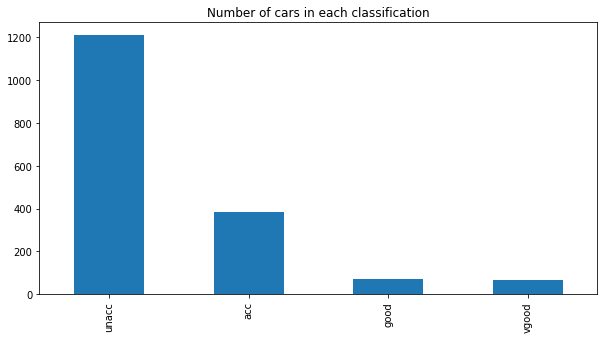

In [16]:
fig = plt.figure(figsize=(10,5))
df.classification.value_counts().plot(kind = 'bar', title ='Number of cars in each classification')

It seems that we have a lot of pretty bad cars! 
Let's take a look in this classification compared with the price.

<Figure size 2880x360 with 0 Axes>

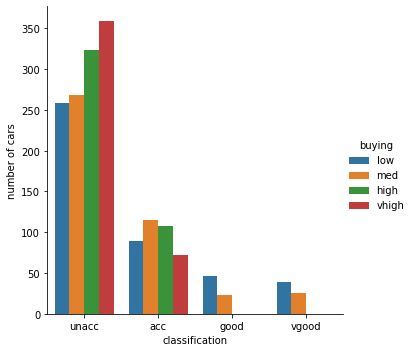

In [17]:
df_buy_class = df.groupby(['buying', 'classification']).count().reset_index()
df_buy_class.rename(columns={'maint': 'number of cars'}, inplace=True)

fig = plt.figure(figsize=(40,5))
sns.catplot(x='classification', y='number of cars', hue='buying', kind="bar", data = df_buy_class)
plt.show()

We can see that cars which good and very good classification have a low or medium price

Now lets see if the buyers consider a safe car acceptable, disregarding the other features

<Figure size 2880x360 with 0 Axes>

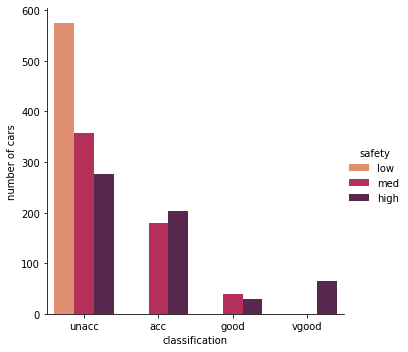

In [18]:
df_safe_class = df.groupby(['safety', 'classification']).count().reset_index()
df_safe_class.rename(columns={'maint': 'number of cars'}, inplace=True)

fig = plt.figure(figsize=(40,5))
sns.catplot(x='classification', y='number of cars', hue='safety', kind="bar", data = df_safe_class, palette='rocket_r')
plt.show()

We can see that all cars that has low safety fits in the unacceptable category. That is a strong indicator of what our classification algorithm should do. On the other hand, being a safe car doesn't mean it's acceptable.


To make it shorter, let's plot the other four variables in subplots

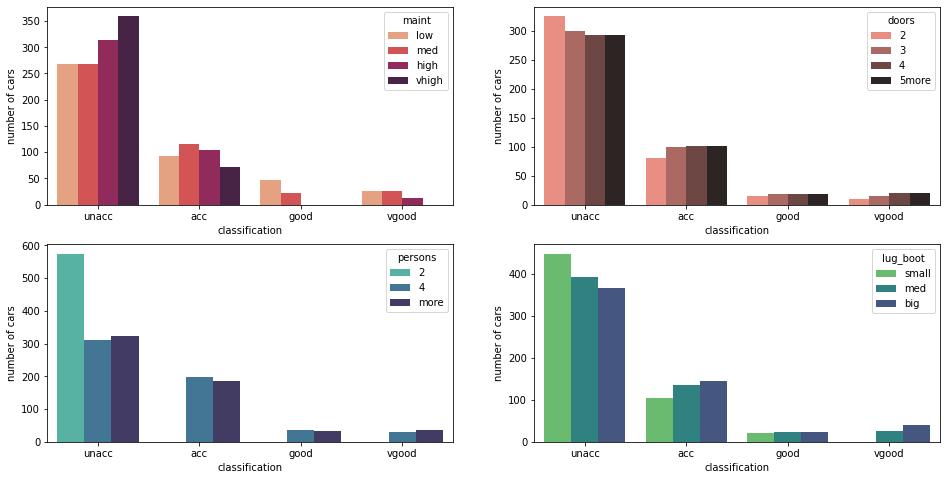

In [19]:
fig, axes = plt.subplots(2,2, figsize = (16,8))

#maintenance
df_maint_class = df.groupby(['maint', 'classification']).count().reset_index()
df_maint_class.rename(columns={'safety': 'number of cars'}, inplace=True)

sns.barplot(ax=axes[0, 0], x='classification', y='number of cars', hue='maint',  data = df_maint_class, palette='rocket_r')


#number of doors
df_doors_class = df.groupby(['doors', 'classification']).count().reset_index()
df_doors_class.rename(columns={'safety': 'number of cars'}, inplace=True)

sns.barplot(ax=axes[0, 1], x='classification', y='number of cars', hue='doors',  data = df_doors_class, palette='dark:salmon_r')

#Max number of persons inside
df_person_class = df.groupby(['persons', 'classification']).count().reset_index()
df_person_class.rename(columns={'safety': 'number of cars'}, inplace=True)

sns.barplot(ax=axes[1, 0], x='classification', y='number of cars', hue='persons',  data = df_person_class, palette='mako_r')

#Size of of luggage boot
df_lug_class = df.groupby(['lug_boot', 'classification']).count().reset_index()
df_lug_class.rename(columns={'safety': 'number of cars'}, inplace=True)

sns.barplot(ax=axes[1, 1], x='classification', y='number of cars', hue='lug_boot',  data = df_lug_class, palette='viridis_r')

plt.show()


From the first graph, we can see that no cars with high maintenance is classified was good or very good. Looking at the second one, we may say that having less or more doors doesn't play a big role in the decision (the proportion it's similar).
In the third graph, it's possible to see that the all cars that fit just 2 people is unacceptable, another trigger that our algorithm should follow.
Looking at the last one, we see that there is no "very good" cars with small luggage boot.

Also, if you know a little bit about cars you know that usually big cars (that fits more people) usually have bigger trunks. So we may have a multicollinearity with these two variables. 
"Multicollinearity is not such a problem for nonlinear regression methods like trees, clustering, and nearest-neighbors" (Source: Practical Statistics for Data Scientists, Peter Bruce, Andrew Bruce & Peter Gedeck)
Therefore, as multicollinearity will affect only the logistic regression model, we will kept both variables.


# Data Preprocessing


In [20]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

Transforming the categorical data into ordinal numbers. We could also tranform it into dummy variables. But as all variablers in orderable (e.g. small, med, high) the best approach is to use Ordinal Encoder

In [21]:
X = np.array(X)
y = np.array(y)

In [22]:
print(X)

[['vhigh' 'vhigh' '2' '2' 'small' 'med']
 ['vhigh' 'vhigh' '2' '2' 'small' 'high']
 ['vhigh' 'vhigh' '2' '2' 'med' 'low']
 ...
 ['low' 'low' '5more' 'more' 'big' 'low']
 ['low' 'low' '5more' 'more' 'big' 'med']
 ['low' 'low' '5more' 'more' 'big' 'high']]


In [23]:
enc = OrdinalEncoder()
X = enc.fit_transform(X)

In [24]:
print(X)

[[3. 3. 0. 0. 2. 2.]
 [3. 3. 0. 0. 2. 0.]
 [3. 3. 0. 0. 1. 1.]
 ...
 [1. 1. 3. 2. 0. 1.]
 [1. 1. 3. 2. 0. 2.]
 [1. 1. 3. 2. 0. 0.]]


# Prediction the evaluation




If we had numerical variables would be nice to feature scale the data. But all variables are transformed into ordinal. We don't need to scale it

Before we dive into machine learning, let's take a look in the metrics we are going to use to evaluate a model 

**Confusion Matrix**

The confusion matrix  helps us to analyse the result. 
In the horizontal we have the predicted values and in the vertical we have the actual values. Here is a nice image to understand it better:


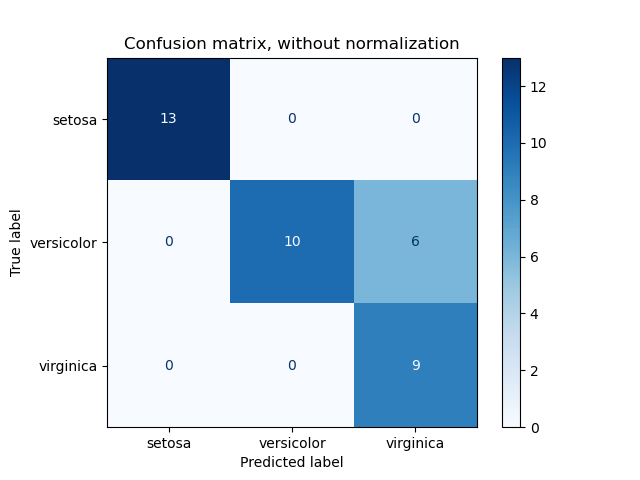

We can see that in the main diagonal we have the values that was correctly guessed. And the rest of the matrix was wrongly guesses 

**Accuracy**

Accuaracy is the proportion of right guesses. It's a measure of total erros

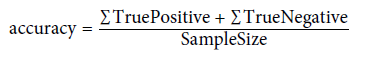



**Precision**

Precision is the accuracy measure of predicted positive outcome. It's the ability to not label a negative outcome as positive. The nearst to one, the lesser false positives will be produced. 

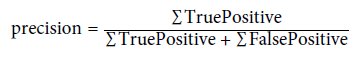  

You can either use all true positives and false positives and calculate a global precision or you can calculate a precision for each label and then take a simple or weighted average. In this case, we are going to use the weighted average to account for label imbalance

**Logistic Regression**

In [25]:
kf = KFold(n_splits = 10)
classifier = LogisticRegression()
y_pred = cross_val_predict(classifier, X, y, cv=kf)

In [26]:
print('Confusion Matrix \n')
print(confusion_matrix(y, y_pred))

accuracy = accuracy_score(y, y_pred)
print('\nAccuracy: {:.3f}'.format(accuracy))

precision = precision_score(y, y_pred, average='weighted')
print('\nPrecision: {:.3f}'.format(precision))

Confusion Matrix 

[[  44    0  301   39]
 [  13    0   56    0]
 [ 128    0 1072    9]
 [  32    0   31    2]]

Accuracy: 0.647

Precision: 0.561


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


K-NN Model

In [27]:
classifier = KNeighborsClassifier(n_neighbors=5, metric = 'minkowski',p = 2) #using Euclidian distance
y_pred = cross_val_predict(classifier, X, y, cv=kf)

print('Confusion Matrix \n')
print(confusion_matrix(y, y_pred))

accuracy = accuracy_score(y, y_pred)
print('\nAccuracy: {:.3f}'.format(accuracy))

precision = precision_score(y, y_pred, average='weighted')
print('\nPrecision: {:.3f}'.format(precision))

Confusion Matrix 

[[ 216   23  124   21]
 [  65    4    0    0]
 [ 109    0 1100    0]
 [  43    0    0   22]]

Accuracy: 0.777

Precision: 0.765


**SVC**

In [28]:
classifier = SVC(kernel = 'linear')
y_pred = cross_val_predict(classifier, X, y, cv=kf)

print('Confusion Matrix \n')
print(confusion_matrix(y, y_pred))

accuracy = accuracy_score(y, y_pred)
print('\nAccuracy: {:.3f}'.format(accuracy))

precision = precision_score(y, y_pred, average='weighted')
print('\nPrecision: {:.3f}'.format(precision))

Confusion Matrix 

[[  66    0  318    0]
 [   0    0   69    0]
 [  38    0 1171    0]
 [  24    0   41    0]]

Accuracy: 0.716

Precision: 0.627


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
classifier = SVC(kernel = 'rbf')
y_pred = cross_val_predict(classifier, X, y, cv=kf)

print('Confusion Matrix \n')
print(confusion_matrix(y, y_pred))

accuracy = accuracy_score(y, y_pred)
print('\nAccuracy: {:.3f}'.format(accuracy))

precision = precision_score(y, y_pred, average='weighted')
print('\nPrecision: {:.3f}'.format(precision))

Confusion Matrix 

[[ 176   21  174   13]
 [  62    2    0    5]
 [ 104    0 1105    0]
 [  13    0    0   52]]

Accuracy: 0.773

Precision: 0.746


**Naive Bayes**

In [30]:
classifier = GaussianNB()
y_pred = cross_val_predict(classifier, X, y, cv=kf)

print('Confusion Matrix \n')
print(confusion_matrix(y, y_pred))

accuracy = accuracy_score(y, y_pred)
print('\nAccuracy: {:.3f}'.format(accuracy))

precision = precision_score(y, y_pred, average='weighted')
print('\nPrecision: {:.3f}'.format(precision))

Confusion Matrix 

[[ 13   0 168 203]
 [ 18   0  21  30]
 [ 38   0 962 209]
 [  0   0   0  65]]

Accuracy: 0.602

Precision: 0.632


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Random Forest**

In [32]:
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy')
output = cross_validate(classifier, X, y, cv=kf, scoring = 'accuracy', return_estimator =True)
y_pred = cross_val_predict(classifier, X, y, cv=kf)

print('Confusion Matrix \n')
print(confusion_matrix(y, y_pred))

accuracy = accuracy_score(y, y_pred)
print('\nAccuracy: {:.3f}'.format(accuracy))

precision = precision_score(y, y_pred, average='weighted')
print('\nPrecision: {:.3f}'.format(precision))

Confusion Matrix 

[[ 289   38   45   12]
 [  53   15    0    1]
 [  97    0 1112    0]
 [  13    0    0   52]]

Accuracy: 0.850

Precision: 0.856


Based in the accuracy and precion score, the model which performed the best is Random Forest

Let's see the feature importance of each variable.
The output is going to be the importance of the variables in each fold created to do the cross-validation.

In [33]:
feature_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']

for idx,estimator in enumerate(output['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index = feature_names,
                                        columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances)

Features sorted by their score for estimator 0:
          importance
safety      0.309711
persons     0.244752
buying      0.161187
maint       0.139879
lug_boot    0.086057
doors       0.058414
Features sorted by their score for estimator 1:
          importance
safety      0.293806
persons     0.230127
buying      0.181092
maint       0.149147
lug_boot    0.089412
doors       0.056416
Features sorted by their score for estimator 2:
          importance
safety      0.294970
persons     0.234624
buying      0.185647
maint       0.141803
lug_boot    0.086534
doors       0.056422
Features sorted by their score for estimator 3:
          importance
safety      0.295272
persons     0.223310
buying      0.178443
maint       0.163150
lug_boot    0.085122
doors       0.054703
Features sorted by their score for estimator 4:
          importance
safety      0.288962
persons     0.218932
maint       0.173864
buying      0.168428
lug_boot    0.092543
doors       0.057271
Features sorted by their 

As wee saw, the importance ranking was the same for each fold. 
The most important variable is safety, followed by maximum number of people inside and price. 
The maintance cost and is also important. Almost so important as price. 
The size of the lugging boot and the number os doors are not so important.

Remember the conclusions we took based on the graphs? We can confirm it looking at the ranking. Which are:
Cars with low safety are unacceptable; cars with high prices are not considered good or very good; cars that fit just 2 people is unacceptable and that having less or more doors doesn't play a big role in the decision

# Comparing the charts







Now let's compare the predicted data with the real data using the same charts we saw before

In [34]:
#transforming X back to it's original format
X = enc.inverse_transform(X)

In [35]:
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y_pred)

In [36]:
pred_df = pd.concat([X_df, y_df], axis=1)
pred_df.columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'classification']

In [37]:
pred_df.head()

,buying,maint,doors,persons,lug_boot,safety,classification
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [38]:
#Changing the sort order
pred_df['buying'] = pd.Categorical(pred_df['buying'], ['low', 'med', 'high', 'vhigh'])
pred_df['maint'] = pd.Categorical(pred_df['maint'], ['low', 'med', 'high','vhigh'])
pred_df['doors'] = pd.Categorical(pred_df['doors'], ['2', '3', '4','5more'])
pred_df['persons'] = pd.Categorical(pred_df['persons'], ['2', '4', 'more'])
pred_df['lug_boot'] = pd.Categorical(pred_df['lug_boot'], ['small', 'med', 'big'])
pred_df['safety'] = pd.Categorical(pred_df['safety'], ['low', 'med', 'high'])
pred_df['classification'] = pd.Categorical(pred_df['classification'], ['unacc', 'acc', 'good', 'vgood'])

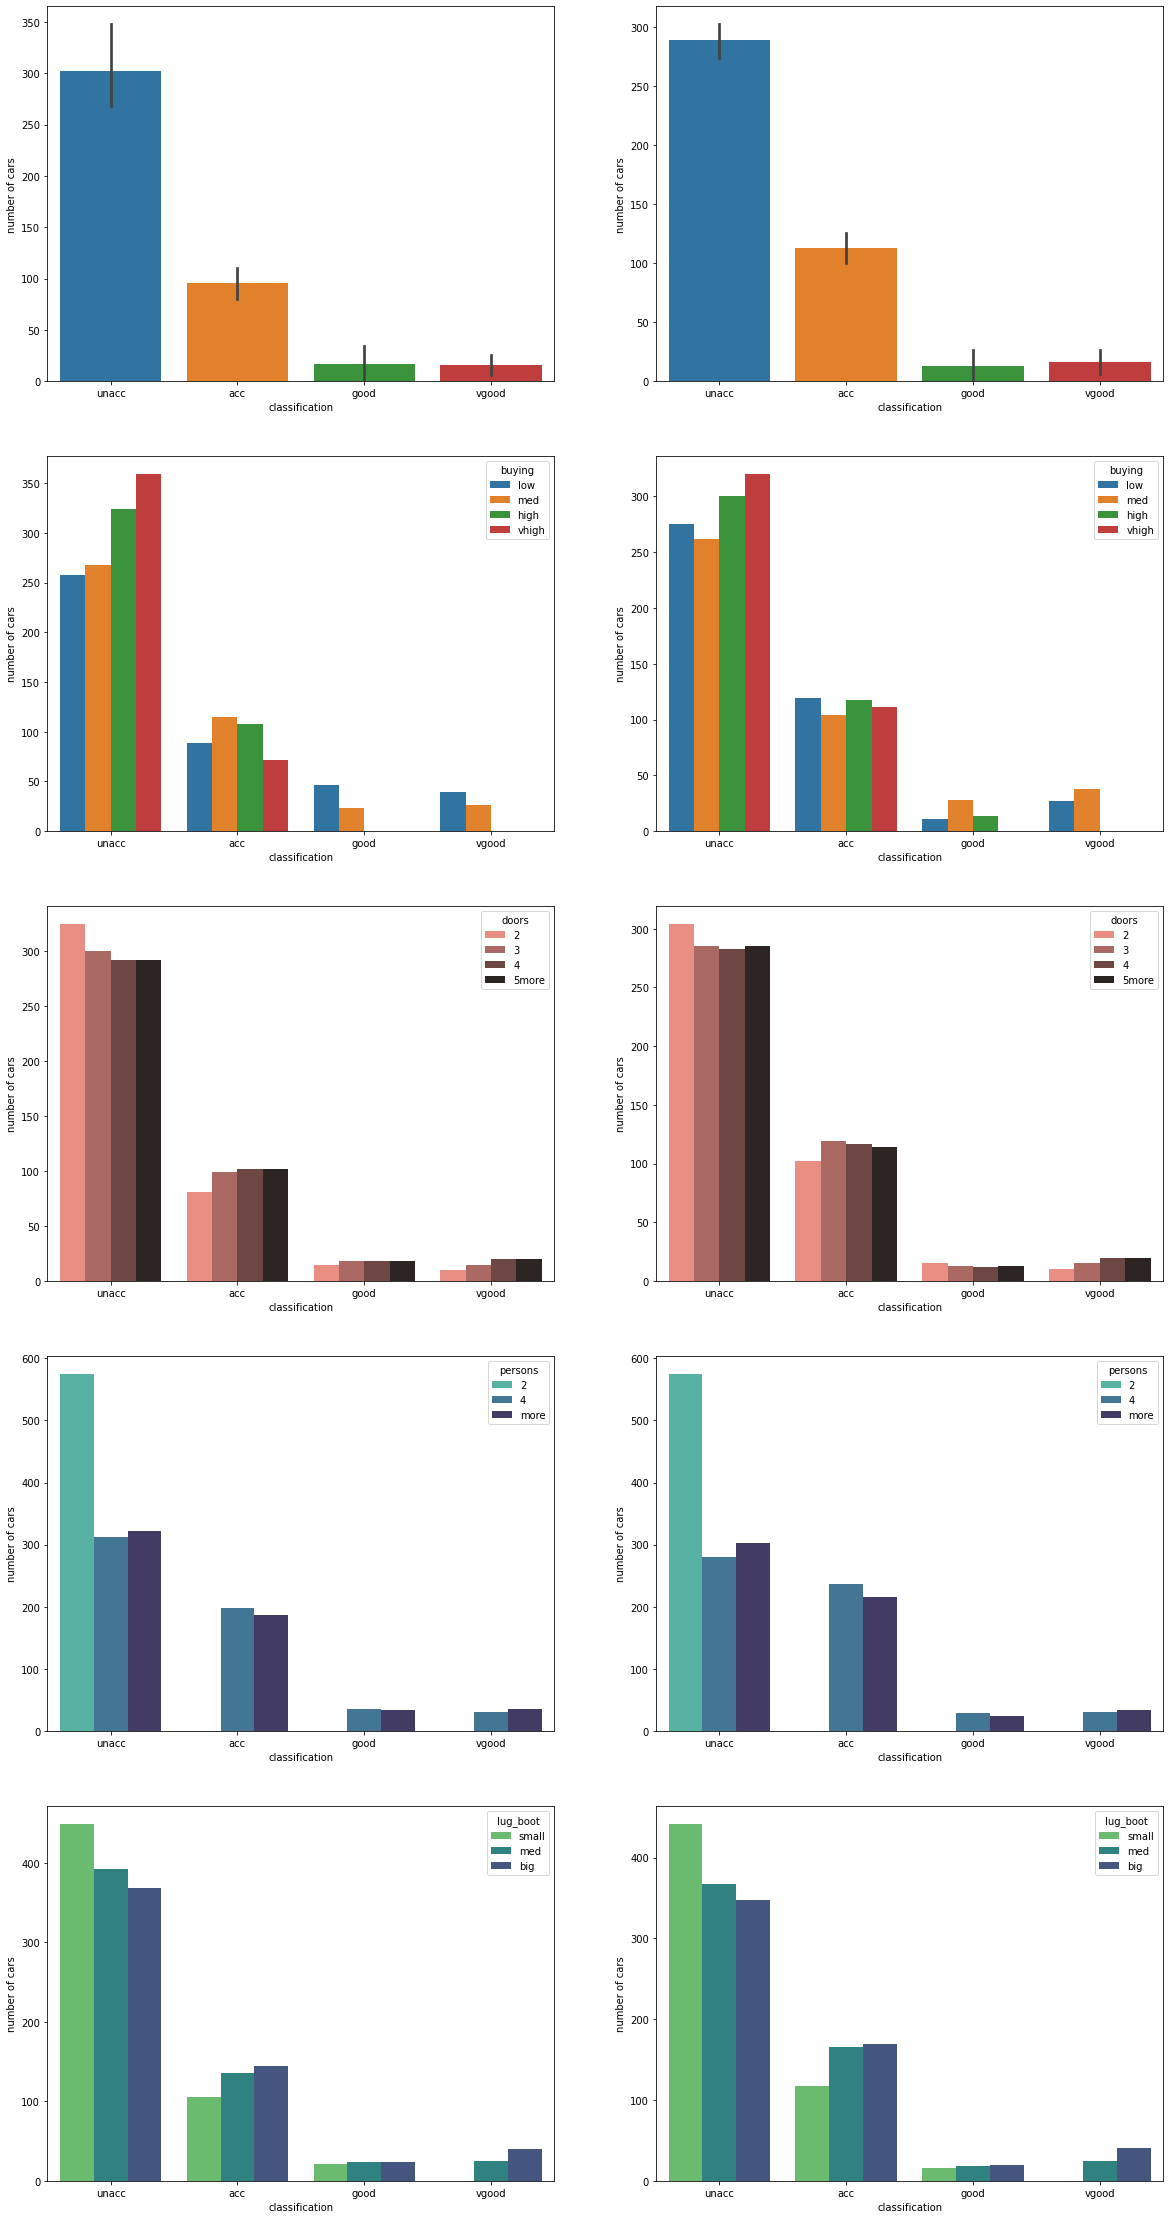

In [39]:
fig, axes = plt.subplots(5,2, figsize = (20,40))

#total number
df_class = df.groupby(['maint', 'classification']).count().reset_index()
df_class.rename(columns={'safety': 'number of cars'}, inplace=True)
sns.barplot(ax=axes[0, 0], x='classification', y='number of cars',  data = df_class)

df_class_pred = pred_df.groupby(['maint', 'classification']).count().reset_index()
df_class_pred.rename(columns={'safety': 'number of cars'}, inplace=True)
sns.barplot(ax=axes[0, 1], x='classification', y='number of cars',  data = df_class_pred)

#buying
df_buy_class = df.groupby(['buying', 'classification']).count().reset_index()
df_buy_class.rename(columns={'maint': 'number of cars'}, inplace=True)
sns.barplot(ax=axes[1, 0], x='classification', y='number of cars', hue='buying', data = df_buy_class)

df_buy_class_pred = pred_df.groupby(['buying', 'classification']).count().reset_index()
df_buy_class_pred.rename(columns={'maint': 'number of cars'}, inplace=True)
sns.barplot(ax=axes[1, 1], x='classification', y='number of cars', hue='buying', data = df_buy_class_pred)

#number of doors
df_doors_class = df.groupby(['doors', 'classification']).count().reset_index()
df_doors_class.rename(columns={'safety': 'number of cars'}, inplace=True)
sns.barplot(ax=axes[2, 0], x='classification', y='number of cars', hue='doors',  data = df_doors_class, palette='dark:salmon_r')

df_doors_class_pred = pred_df.groupby(['doors', 'classification']).count().reset_index()
df_doors_class_pred.rename(columns={'safety': 'number of cars'}, inplace=True)
sns.barplot(ax=axes[2, 1], x='classification', y='number of cars', hue='doors',  data = df_doors_class_pred, palette='dark:salmon_r')

#Max number of persons inside
df_person_class = df.groupby(['persons', 'classification']).count().reset_index()
df_person_class.rename(columns={'safety': 'number of cars'}, inplace=True)
sns.barplot(ax=axes[3, 0], x='classification', y='number of cars', hue='persons',  data = df_person_class, palette='mako_r')

df_person_class_pred = pred_df.groupby(['persons', 'classification']).count().reset_index()
df_person_class_pred.rename(columns={'safety': 'number of cars'}, inplace=True)
sns.barplot(ax=axes[3, 1], x='classification', y='number of cars', hue='persons',  data = df_person_class_pred, palette='mako_r')


#Size of of luggage boot
df_lug_class = df.groupby(['lug_boot', 'classification']).count().reset_index()
df_lug_class.rename(columns={'safety': 'number of cars'}, inplace=True)
sns.barplot(ax=axes[4, 0], x='classification', y='number of cars', hue='lug_boot',  data = df_lug_class, palette='viridis_r')

df_lug_class_pred = pred_df.groupby(['lug_boot', 'classification']).count().reset_index()
df_lug_class_pred.rename(columns={'safety': 'number of cars'}, inplace=True)
sns.barplot(ax=axes[4, 1], x='classification', y='number of cars', hue='lug_boot',  data = df_lug_class_pred, palette='viridis_r')


In the left side we have the real data and in the right we can see the predicted data.
From the second is posible to notice that some car was misclassified as good. Also there are some difference between the two dataframes.
In the other graphs the difference subtle.
Therefore, we can conclude that the model was effective in classifying the cars. 
Of course, the model could still be optimized